In [155]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, LSTM, SimpleRNN
from keras.models import Model, Sequential
import pandas as pd
#import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from keras.preprocessing.sequence import TimeseriesGenerator
import keras

In [156]:
import os  # avoid kernal die
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [157]:
def plot_loss(history, title):
# summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss: ' + title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    print('MSE val = ', history.history['val_loss'][-1])

In [158]:
def plot_y_yhat(x_test, y_test, model, title):
#y_pred = model.predict(X_test)
    y_hat = model.predict(x_test)
    Time_test = np.arange(0, len(y_hat))
    plt.figure(figsize=(20,10))
    plt.plot(Time_test, y_hat, '-+', Time_test, y_test)
    plt.legend(['Predicted', 'True'], loc='upper right')
    plt.title('Y vs Yhat: ' + title)
    results = model.evaluate(x_test, y_test)
    print("test loss, test acc:", results)

In [159]:
dataset = pd.read_csv('AAPL_hist_data.csv')

In [160]:
dataset.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [161]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/29/2022,176.690002,179.009995,176.339996,178.960007,177.882446,100589400
1,3/30/2022,178.550003,179.610001,176.699997,177.770004,176.699615,92633200
2,3/31/2022,177.839996,178.029999,174.399994,174.610001,173.558640,103049300
3,4/1/2022,174.029999,174.880005,171.940002,174.309998,173.260437,78751300
4,4/4/2022,174.570007,178.490005,174.440002,178.440002,177.365570,76468400


In [162]:
dataset.shape

(251, 7)

In [163]:
train_set = dataset.iloc[:,1:2].values

In [164]:
type(train_set)

numpy.ndarray

In [165]:
train_set.shape

(251, 1)

In [166]:
train_set.T

array([[176.690002, 178.550003, 177.839996, 174.029999, 174.570007,
        177.5     , 172.360001, 171.160004, 171.779999, 168.710007,
        168.020004, 167.389999, 170.619995, 163.919998, 165.020004,
        168.759995, 168.910004, 166.460007, 161.119995, 162.25    ,
        155.910004, 159.25    , 161.839996, 156.710007, 158.149994,
        159.669998, 163.850006, 156.009995, 154.929993, 155.520004,
        153.5     , 142.770004, 144.589996, 145.550003, 148.860001,
        146.850006, 139.880005, 139.089996, 137.789993, 140.809998,
        138.429993, 137.389999, 145.389999, 149.070007, 149.899994,
        147.830002, 146.899994, 147.029999, 144.350006, 148.580002,
        147.080002, 140.279999, 132.869995, 133.130005, 134.289993,
        132.080002, 130.070007, 133.419998, 134.789993, 136.820007,
        139.899994, 142.699997, 142.130005, 137.460007, 137.25    ,
        136.039993, 137.770004, 141.350006, 143.289993, 145.259995,
        145.669998, 145.759995, 142.990005, 144.

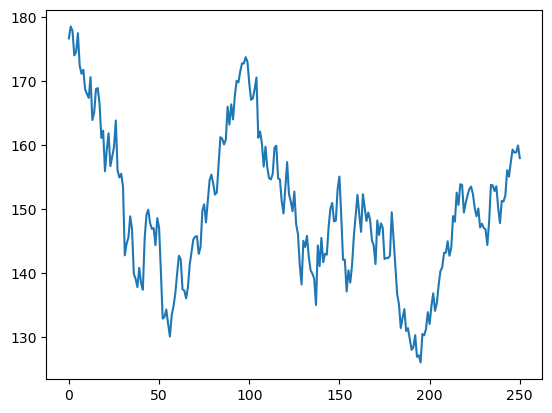

In [167]:
plt.plot(train_set)

In [168]:
train_size = int(len(train_set) * 0.8)
test_size = len(train_set) - train_size
train = train_set[:train_size]
test = train_set[train_size:]

train = train.reshape(-1,1)
test = test.reshape(-1,1)
print(train.shape, test.shape)

# simple scaling
#train = train/np.max(train)
#test = test/np.max(test)

(200, 1) (51, 1)


In [186]:
time_steps = 10
n = 2 # prediction y(t+n) ahead
# Train sets
m_train = len(train)
m_star = m_train - time_steps - n +1
X_train =np.zeros((m_star, time_steps))
y_train = np.zeros((m_star, 1))
#X_train.shape
for i in range(m_star):
    X_train[i,:] = train[i:i+time_steps].flatten()
    y_train[i] = train[i+time_steps-1+n]

# Test sets
m_test = len(test)
m_star = m_test - time_steps - n +1
X_test =np.zeros((m_star, time_steps))
y_test = np.zeros((m_star, 1))
#X_test.shape
for i in range(m_star):
    X_test[i,:] = test[i:i+time_steps].flatten()
    y_test[i] = test[i+time_steps-1+n]

In [187]:
print('X_train and y_train shapes: ', [X_train.shape, y_train.shape])
print('X_test and y_test shapes: ', [X_test.shape, y_test.shape])

X_train and y_train shapes:  [(189, 10), (189, 1)]
X_test and y_test shapes:  [(40, 10), (40, 1)]


In [188]:
m_train-time_steps-n+1

189

In [189]:
X_train

array([[176.690002, 178.550003, 177.839996, ..., 171.160004, 171.779999,
        168.710007],
       [178.550003, 177.839996, 174.029999, ..., 171.779999, 168.710007,
        168.020004],
       [177.839996, 174.029999, 174.570007, ..., 168.710007, 168.020004,
        167.389999],
       ...,
       [134.350006, 130.919998, 131.380005, ..., 126.889999, 127.129997,
        126.010002],
       [130.919998, 131.380005, 129.669998, ..., 127.129997, 126.010002,
        130.470001],
       [131.380005, 129.669998, 127.989998, ..., 126.010002, 130.470001,
        130.259995]])

In [190]:
y_train

array([[167.389999],
       [170.619995],
       [163.919998],
       [165.020004],
       [168.759995],
       [168.910004],
       [166.460007],
       [161.119995],
       [162.25    ],
       [155.910004],
       [159.25    ],
       [161.839996],
       [156.710007],
       [158.149994],
       [159.669998],
       [163.850006],
       [156.009995],
       [154.929993],
       [155.520004],
       [153.5     ],
       [142.770004],
       [144.589996],
       [145.550003],
       [148.860001],
       [146.850006],
       [139.880005],
       [139.089996],
       [137.789993],
       [140.809998],
       [138.429993],
       [137.389999],
       [145.389999],
       [149.070007],
       [149.899994],
       [147.830002],
       [146.899994],
       [147.029999],
       [144.350006],
       [148.580002],
       [147.080002],
       [140.279999],
       [132.869995],
       [133.130005],
       [134.289993],
       [132.080002],
       [130.070007],
       [133.419998],
       [134.7

In [191]:
train_set

array([[176.690002],
       [178.550003],
       [177.839996],
       [174.029999],
       [174.570007],
       [177.5     ],
       [172.360001],
       [171.160004],
       [171.779999],
       [168.710007],
       [168.020004],
       [167.389999],
       [170.619995],
       [163.919998],
       [165.020004],
       [168.759995],
       [168.910004],
       [166.460007],
       [161.119995],
       [162.25    ],
       [155.910004],
       [159.25    ],
       [161.839996],
       [156.710007],
       [158.149994],
       [159.669998],
       [163.850006],
       [156.009995],
       [154.929993],
       [155.520004],
       [153.5     ],
       [142.770004],
       [144.589996],
       [145.550003],
       [148.860001],
       [146.850006],
       [139.880005],
       [139.089996],
       [137.789993],
       [140.809998],
       [138.429993],
       [137.389999],
       [145.389999],
       [149.070007],
       [149.899994],
       [147.830002],
       [146.899994],
       [147.0

In [192]:
m = len(y_train)
nx = 1 # dim of x<t>
print('m, time_steps, n = look_ahead, nx: ', m, time_steps, n, nx)

m, time_steps, n = look_ahead, nx:  189 10 2 1


In [244]:
# RNN #
hidden_neurons = 200
model = Sequential()
model.add(SimpleRNN(units=hidden_neurons, input_shape=(time_steps, nx)))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation=None))
opt=keras.optimizers.Adam()

model.compile(loss='mean_squared_error',optimizer=opt)
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_28 (SimpleRNN)   (None, 200)               40400     
                                                                 
 dense_22 (Dense)            (None, 100)               20100     
                                                                 
 dense_23 (Dense)            (None, 1)                 101       
                                                                 
Total params: 60,601
Trainable params: 60,601
Non-trainable params: 0
_________________________________________________________________


In [260]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=True
)

Epoch 1/100
11/11 [==============================] - 0s 20ms/step - loss: 20.2585 - val_loss: 58.1275
Epoch 2/100
11/11 [==============================] - 0s 11ms/step - loss: 19.5616 - val_loss: 74.9658
Epoch 3/100
11/11 [==============================] - 0s 21ms/step - loss: 21.3937 - val_loss: 71.7215
Epoch 4/100
11/11 [==============================] - 0s 11ms/step - loss: 20.7592 - val_loss: 58.5774
Epoch 5/100
11/11 [==============================] - 0s 13ms/step - loss: 21.7570 - val_loss: 50.1003
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 22.6234 - val_loss: 57.6394
Epoch 7/100
11/11 [==============================] - 0s 12ms/step - loss: 23.9971 - val_loss: 38.4464
Epoch 8/100
11/11 [==============================] - 0s 11ms/step - loss: 22.3036 - val_loss: 49.9928
Epoch 9/100
11/11 [==============================] - 0s 11ms/step - loss: 21.1956 - val_loss: 56.1039
Epoch 10/100
11/11 [==============================] - 0s 12ms/step - loss: 19.1451

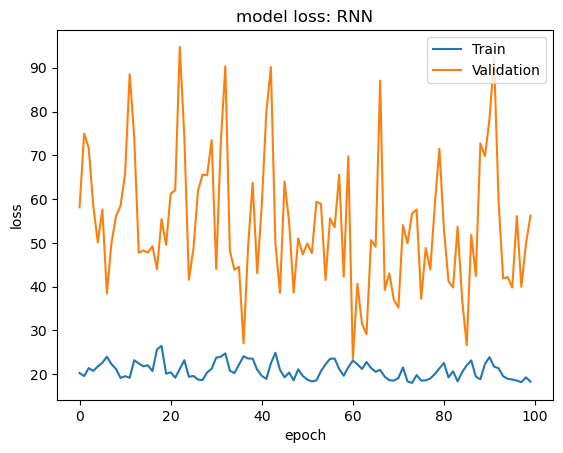

MSE val =  56.242374420166016
6/6 [==============================] - 0s 7ms/step - loss: 22.1914
test loss, test acc: 22.191360473632812


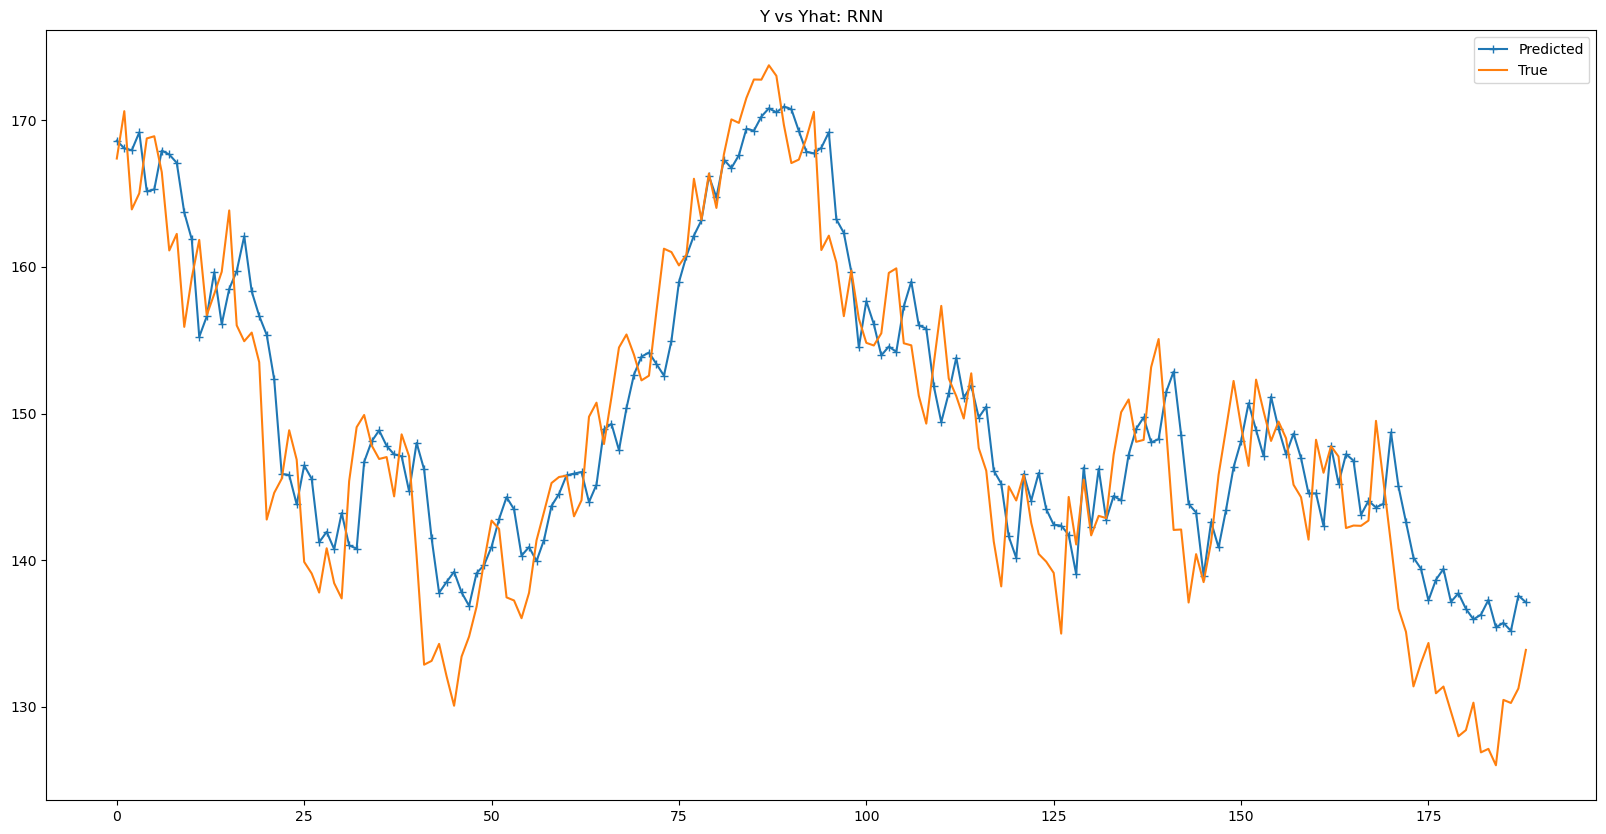

In [261]:
plot_loss(history, 'RNN')

plot_y_yhat(X_train, y_train, model, 'RNN')   # runs model.predict in function

In [262]:
yhat_test = model.predict(X_test)

2/2 [==============================] - 0s 0s/step


2/2 [==============================] - 0s 0s/step - loss: 12.4532
test loss, test acc: 12.453193664550781


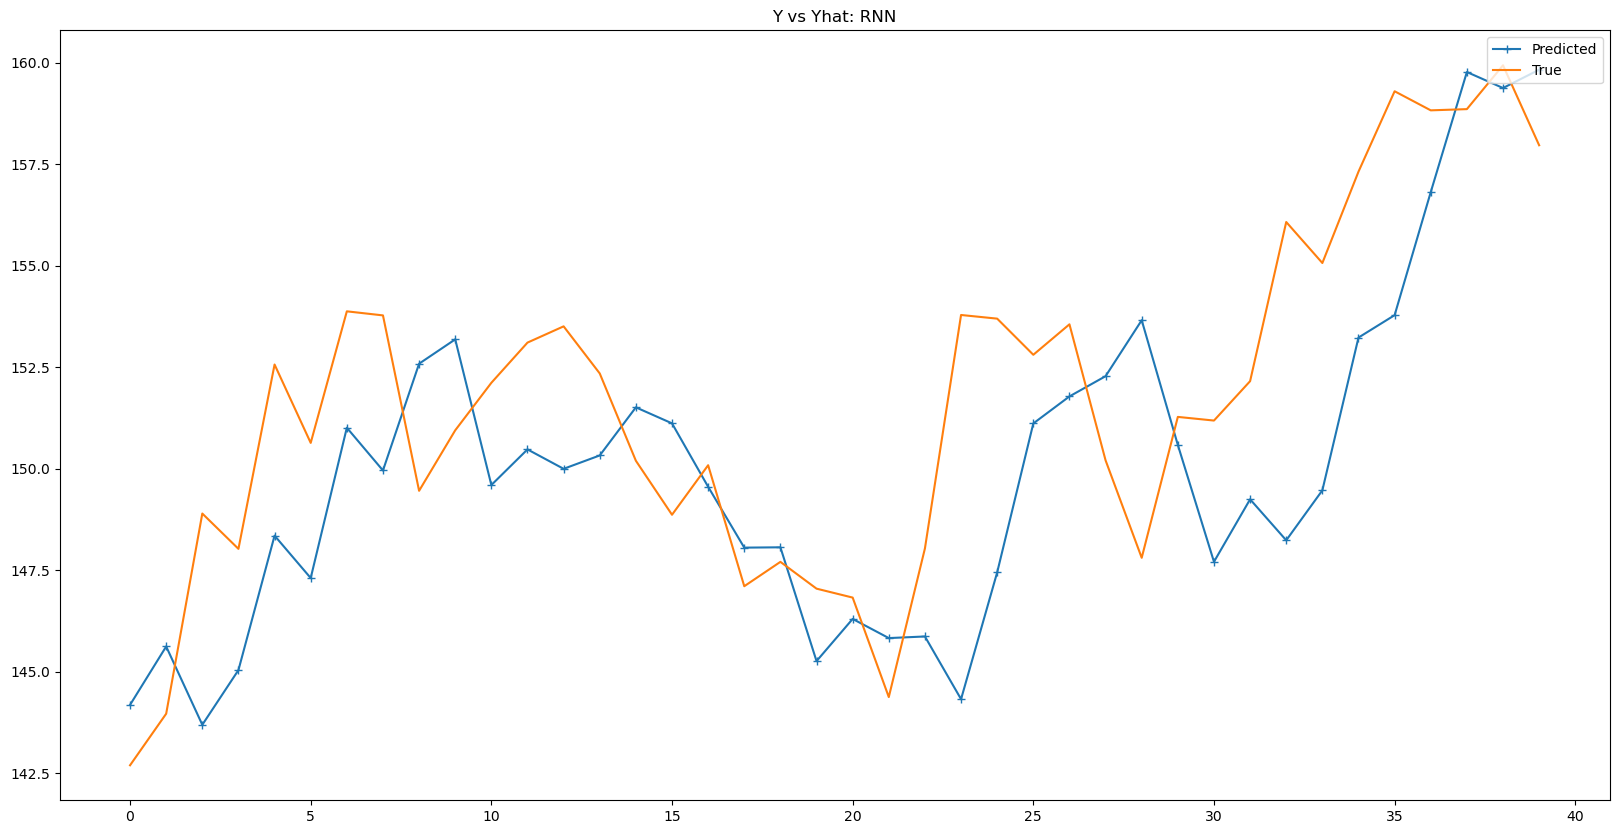

In [263]:
plot_y_yhat(X_test, y_test, model, 'RNN')   # runs model.predict in function

In [265]:
# Assuming you have your test data X_test and y_test prepared

# Make predictions on the test set
predictions = model.predict(X_test)

# Calculate percentage error for each prediction
percentage_errors = np.abs((predictions - y_test) / y_test) * 100

# Check if all percentage errors are within +/-10%
target_met = np.all(percentage_errors <= 10)

if target_met:
    print("Performance target met: All predictions have less than +/-10% error.")
else:
    print("Performance target not met: Some predictions have more than +/-10% error.")

max_error = np.max(percentage_errors)
print("Maximum percentage error:", max_error)


2/2 [==============================] - 0s 3ms/step
Performance target met: All predictions have less than +/-10% error.
Maximum percentage error: 6.152489893388054
